# **프로젝트 : 주식 예측에 도전해 보자**

In [ ]:
!pip install --upgrade statsmodels

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import statsmodels
print(statsmodels.__version__)

0.13.2


# TSLA(테슬라)

**STEP 1 : 시계열 데이터 준비**

In [ ]:
filename = '/content/drive/MyDrive/코드 및 데이터파일/TSLA.csv'
df = pd.read_csv(filename, index_col='Date', parse_dates=True)
ts = df['Close']

ts.tail()

Date
2022-04-26    876.419983
2022-04-27    881.510010
2022-04-28    877.510010
2022-04-29    870.760010
2022-05-02    902.940002
Name: Close, dtype: float64

**STEP 2 : 전처리 수행**

In [ ]:
# 결측치 확인: 결측치가 있다면, 두가지 방법으로 처리 가능
#1. 결측치가 있는 데이터를 모두 삭제(drop)
#2. 결측치 양 옆의 값들을 이용해서 적절히 보간(interpolate) -> 시계열에서 더 적절함

ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없는 것을 확인하였다.

In [ ]:
# 로그 변환: 분산이 커지는 것을 방지하고 안정적으로 만들기 위한 작업
ts_log = np.log(ts)

**STEP 3 : 시계열 안정성 분석**

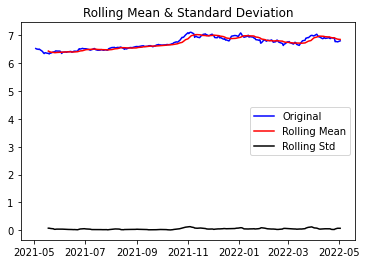

In [ ]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
plot_rolling_statistics(ts_log, window=12)

In [ ]:
#정량적 Augmented Dicky-Fuller Test
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.430377
p-value                          0.567630
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


p-value가 약 0.57인것을 확인
귀무가설에 따라, 안정적이지 않은 시계열임을 판단할 수 있다.

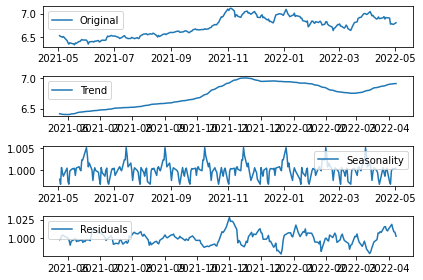

In [ ]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual 안정성 확인: Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.863439e+00
p-value                        1.581000e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


시계열 분해 작업을 한 후 확인한 결과, p-value가 매우 낮아진 것을 확인할 수 있다. 이는 대립가설인 '시계열이 안정적이다'의 근거가 된다.

**STEP 4 : 학습, 테스트 데이터셋 생성**

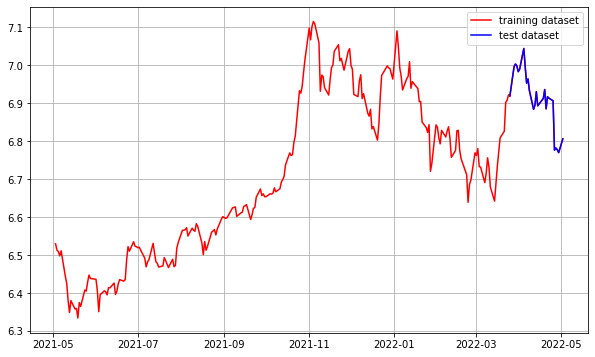

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

**STEP 5 : 적정 ARIMA 모수 찾기**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


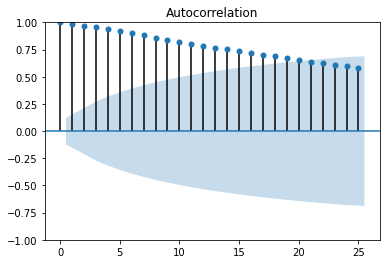

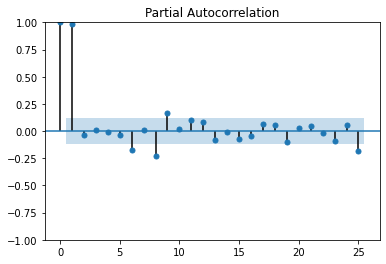

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

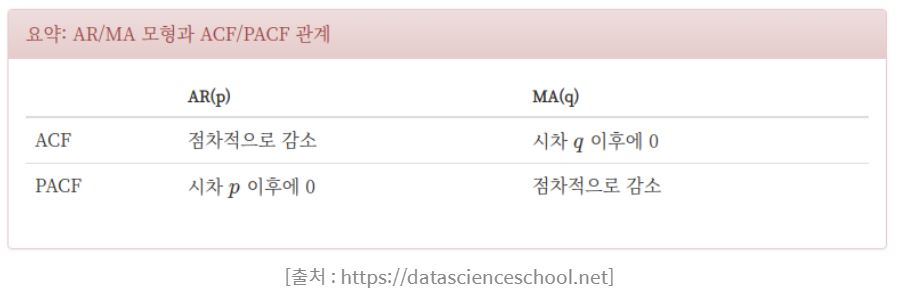

위의 관계에 근거하여, PACF 그래프를 확인하면 p=1이 적합한 것을 알 수 있다. 

(p가 2 이상인 구간에서는 0에 가깝기 때문)

반면에, ACF는 점차적으로 감소하고 있음을 확인할 수 있다.

q에 관해서는 적합한 값이 없어보이므로, MA를 고려하지 않고 0으로 둘 수 있다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.543666e+01
p-value                        2.901063e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.526468e+00
p-value                        3.673564e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


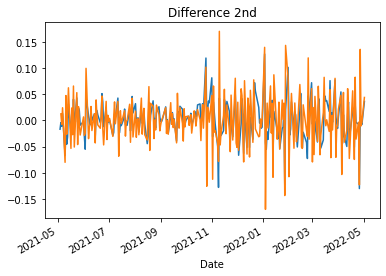

In [ ]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

**STEP 6 : ARIMA 모델 훈련과 테스트**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model

model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 446.173
Date:                Thu, 05 May 2022   AIC                           -886.346
Time:                        03:27:58   BIC                           -876.072
Sample:                             0   HQIC                          -882.200
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6987      0.176     38.039      0.000       6.354       7.044
ar.L1          0.9880      0.011     87.888      0.000       0.966       1.010
sigma2         0.0011   7.31e-05     15.457      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


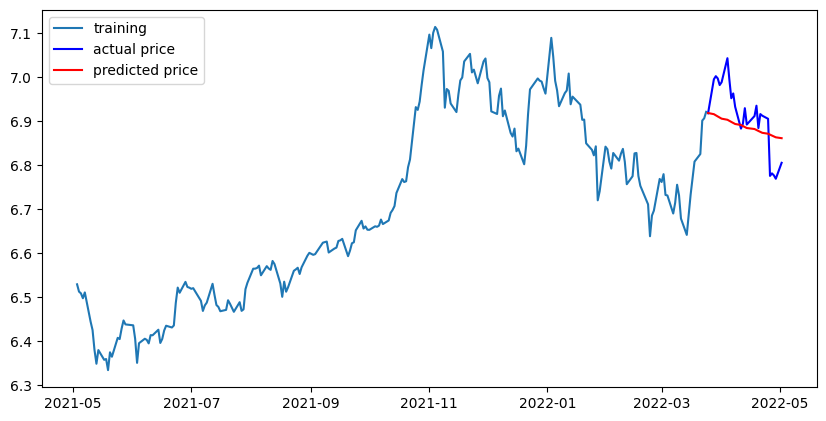

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4578.560757557153
MAE:  57.41358118465447
RMSE:  67.66506304997544
MAPE: 5.67%


**Summary**

결과적으로 MAPE 5.67%을 얻을 수 있었다. 차분의 횟수와 p의 값을 수정하며 여러차례 시도해 보았으나, 결과적으로 차분을 하지 않고 위의 그래프 분석대로 p=1일때, 가장 낮은 수치를 얻을 수 있었다.

# DIS(디즈니)

**STEP 1 : 시계열 데이터 준비**

In [79]:
filename2 = '/content/drive/MyDrive/코드 및 데이터파일/DIS.csv'
df2 = pd.read_csv(filename2, index_col='Date', parse_dates=True)
ts2 = df2['Close']

ts2.tail()

Date
2022-04-28    115.290001
2022-04-29    111.629997
2022-05-02    113.500000
2022-05-03    113.550003
2022-05-04    116.190002
Name: Close, dtype: float64

**STEP 2 : 전처리 수행**

In [80]:
# 결측치 확인: 결측치가 있다면, 두가지 방법으로 처리 가능
#1. 결측치가 있는 데이터를 모두 삭제(drop)
#2. 결측치 양 옆의 값들을 이용해서 적절히 보간(interpolate) -> 시계열에서 더 적절함

ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없는 것을 확인하였다.

In [81]:
# 로그 변환: 분산이 커지는 것을 방지하고 안정적으로 만들기 위한 작업
ts2_log = np.log(ts2)

**STEP 3 : 시계열 안정성 분석**

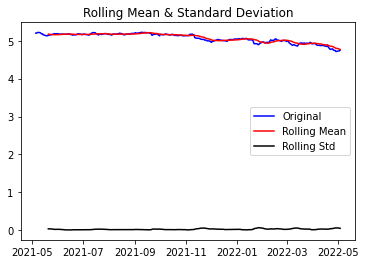

In [82]:
# 정성적 그래프 분석
# 위에서 정의한 plot_rolling_statistics 함수 이용
plot_rolling_statistics(ts2_log, window=12)

In [83]:
#정량적 Augmented Dicky-Fuller Test
#위에서 정의한 augmented_dickey_fuller_test 함수 이용
    
augmented_dickey_fuller_test(ts2_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.199233
p-value                          0.972219
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


p-value가 약 0.97인것을 확인
귀무가설에 따라, 안정적이지 않은 시계열임을 판단할 수 있다.

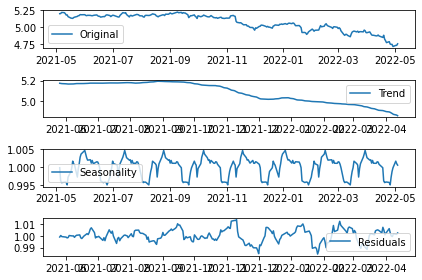

In [84]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition2 = seasonal_decompose(ts2_log, model='multiplicative', period=30) 
trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [85]:
# Residual 안정성 확인: Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                -6.219592e+00
p-value                        5.262903e-08
#Lags Used                     1.300000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


시계열 분해 작업을 한 후 확인한 결과, p-value가 매우 낮아진 것을 확인할 수 있다. 이는 대립가설인 '시계열이 안정적이다'의 근거가 된다.

**STEP 4 : 학습, 테스트 데이터셋 생성**

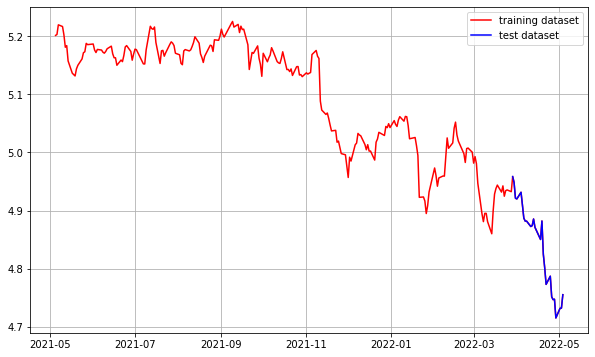

In [86]:
train_data2, test_data2 = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()

**STEP 5 : 적정 ARIMA 모수 찾기**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


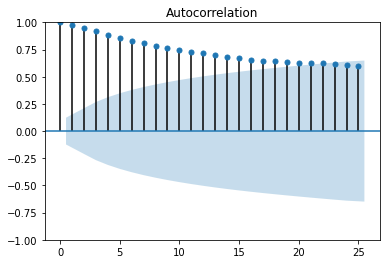

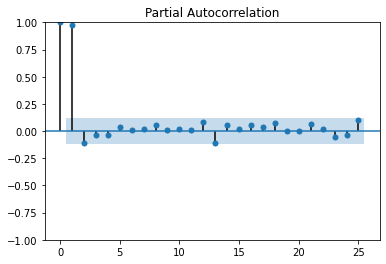

In [87]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

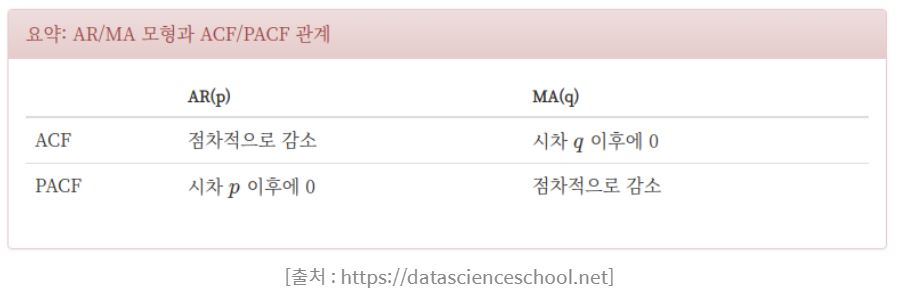

위의 관계에 근거하여, PACF 그래프를 확인하면 p=1이 적합한 것을 알 수 있다. 

(p가 2 이상인 구간에서는 0에 가깝기 때문)

반면에, ACF는 점차적으로 감소하고 있음을 확인할 수 있다.

q에 관해서는 적합한 값이 없어보이므로, MA를 고려하지 않고 0으로 둘 수 있다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.431933e+01
p-value                        1.148394e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.345034e+00
p-value                        3.101918e-13
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


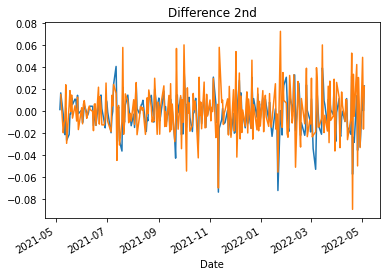

In [120]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff2_1 = ts2_log.diff(periods=1).iloc[1:]
diff2_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff2_1)

# 혹시 필요한 경우 2차 차분 구하기
diff2_2 = diff2_1.diff(periods=1).iloc[1:]
diff2_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff2_2)

**STEP 6 : ARIMA 모델 훈련과 테스트**

In [124]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model

model2 = ARIMA(train_data2, order=(1, 2, 0))  
fitted_m2 = model2.fit() 

print(fitted_m2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 570.203
Date:                Thu, 05 May 2022   AIC                          -1136.406
Time:                        03:53:56   BIC                          -1129.574
Sample:                             0   HQIC                         -1133.649
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4231      0.057     -7.418      0.000      -0.535      -0.311
sigma2         0.0004   2.78e-05     13.232      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   2.60   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


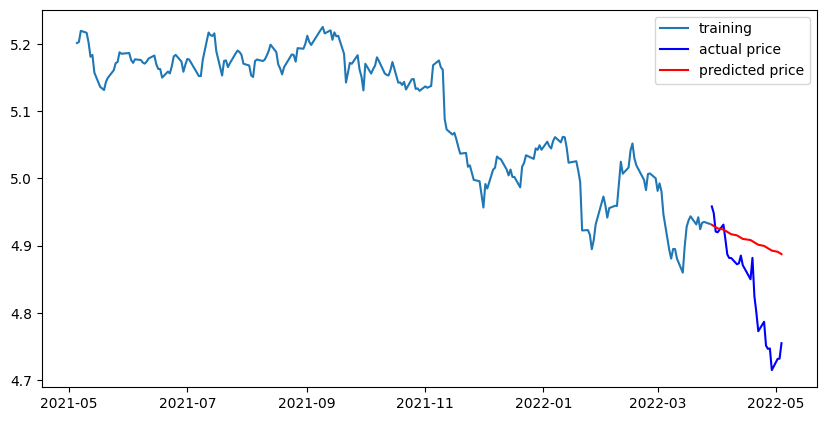

In [130]:
# Forecast : 결과가 fc에 담깁니다. 
fc2 = fitted_m2.forecast(len(test_data2), alpha=0.05)  # 95% conf
fc2 = np.array(fc2)
# Make as pandas series
fc_series2 = pd.Series(fc2, index=test_data2.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.legend()
plt.show()

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc2))
print('MSE: ', mse2)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc2))
print('MAE: ', mae2)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2)))
print('RMSE: ', rmse2)

mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape2*100))

MSE:  135.52500583571563
MAE:  9.312232777628697
RMSE:  11.641520769887224
MAPE: 7.79%


**Summary**

결과적으로 MAPE 7.79%을 얻을 수 있었다. 차분의 횟수와 p의 값을 수정하며 여러차례 시도해 본 결과, 위의 그래프 분석대로 p=1이며 2차 차분까지 완료했을 때 가장 최적화된 MAPE값을 얻을 수 있었다. 주가 그래프 상에서, 크게 하락하는 구간이 여러번 있었던 것으로 보이는데 이 때문에 전체적인 시계열 그래프가 불안정 했고, 여러번의 차분을 통해 안정성을 더 갖출 수 있었기 때문에 2차 차분에서 가장 우수한 모델의 성능을 보여준 것으로 판단한다.

# FB(메타)

**STEP 1 : 시계열 데이터 준비**

In [108]:
filename3 = '/content/drive/MyDrive/코드 및 데이터파일/FB.csv'
df3 = pd.read_csv(filename3, index_col='Date', parse_dates=True)
ts3 = df3['Close']

ts3.tail()

Date
2022-04-28    205.729996
2022-04-29    200.470001
2022-05-02    211.130005
2022-05-03    212.029999
2022-05-04    223.410004
Name: Close, dtype: float64

**STEP 2 : 전처리 수행**

In [109]:
# 결측치 확인: 결측치가 있다면, 두가지 방법으로 처리 가능
#1. 결측치가 있는 데이터를 모두 삭제(drop)
#2. 결측치 양 옆의 값들을 이용해서 적절히 보간(interpolate) -> 시계열에서 더 적절함

ts3 = ts3.interpolate(method='time')
ts3[ts3.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없는 것을 확인하였다.

In [110]:
# 로그 변환: 분산이 커지는 것을 방지하고 안정적으로 만들기 위한 작업
ts3_log = np.log(ts3)

**STEP 3 : 시계열 안정성 분석**

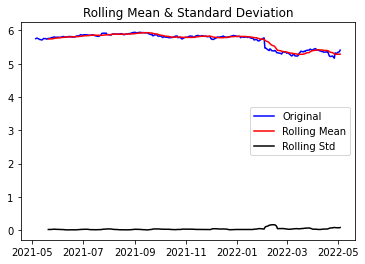

In [113]:
# 정성적 그래프 분석
# 위에서 정의한 plot_rolling_statistics 함수 이용
plot_rolling_statistics(ts3_log, window=12)

In [114]:
#정량적 Augmented Dicky-Fuller Test
#위에서 정의한 augmented_dickey_fuller_test 함수 이용
    
augmented_dickey_fuller_test(ts3_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.731728
p-value                          0.838359
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


p-value가 약 0.84인것을 확인
귀무가설에 따라, 안정적이지 않은 시계열임을 판단할 수 있다.

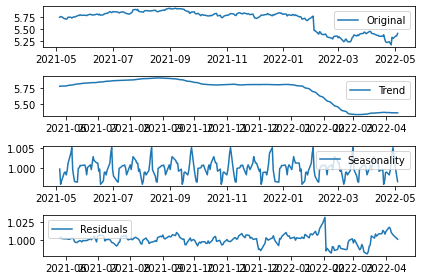

In [117]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition3 = seasonal_decompose(ts3_log, model='multiplicative', period=30) 
trend3 = decomposition3.trend
seasonal3 = decomposition3.seasonal
residual3 = decomposition3.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend3, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal3,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual3, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [116]:
# Residual 안정성 확인: Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지
residual3.dropna(inplace=True)
augmented_dickey_fuller_test(residual3)

Results of Dickey-Fuller Test:
Test Statistic                  -5.120906
p-value                          0.000013
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


시계열 분해 작업을 한 후 확인한 결과, p-value가 매우 낮아진 것을 확인할 수 있다. 이는 대립가설인 '시계열이 안정적이다'의 근거가 된다.

**STEP 4 : 학습, 테스트 데이터셋 생성**

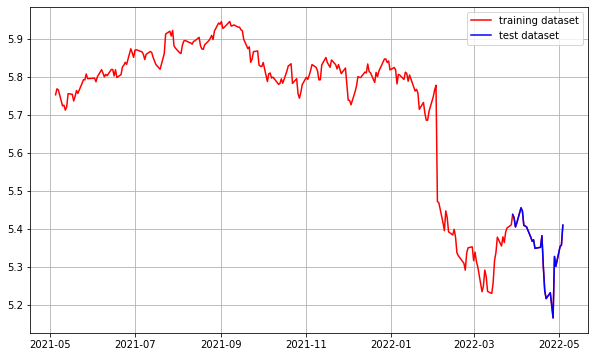

In [118]:
train_data3, test_data3 = ts3_log[:int(len(ts3_log)*0.9)], ts3_log[int(len(ts3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data3, c='b', label='test dataset')
plt.legend()

**STEP 5 : 적정 ARIMA 모수 찾기**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


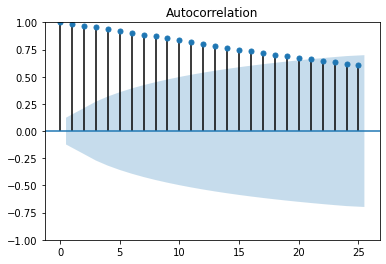

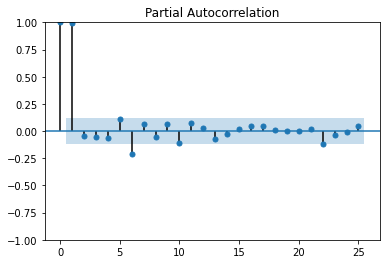

In [119]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts3_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

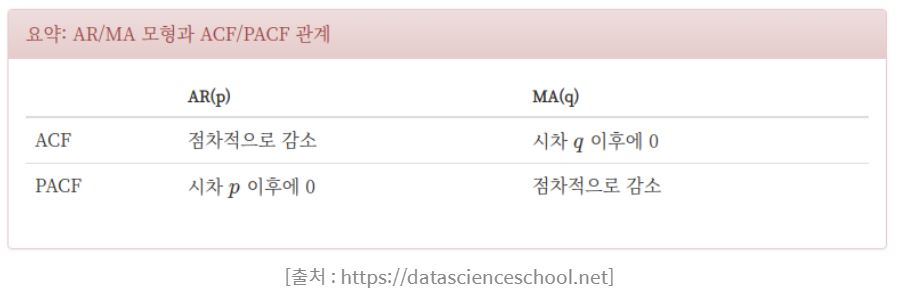

위의 관계에 근거하여, PACF 그래프를 확인하면 p=1이 적합한 것을 알 수 있다. 

(p가 2 이상인 구간에서는 0에 가깝기 때문)

반면에, ACF는 점차적으로 감소하고 있음을 확인할 수 있다.

q에 관해서는 적합한 값이 없어보이므로, MA를 고려하지 않고 0으로 둘 수 있다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.543666e+01
p-value                        2.901063e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.345034e+00
p-value                        3.101918e-13
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


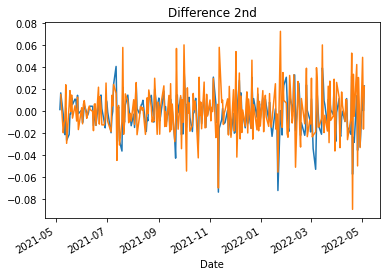

In [ ]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff3_1 = ts3_log.diff(periods=1).iloc[1:]
diff3_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff3_1)

# 혹시 필요한 경우 2차 차분 구하기
diff3_2 = diff3_1.diff(periods=1).iloc[1:]
diff3_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff3_2)

**STEP 6 : ARIMA 모델 훈련과 테스트**

In [141]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model

model3 = ARIMA(train_data3, order=(1, 1, 0))  
fitted_m3 = model3.fit() 

print(fitted_m3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 480.376
Date:                Thu, 05 May 2022   AIC                           -956.752
Time:                        03:59:10   BIC                           -949.911
Sample:                             0   HQIC                          -953.991
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0145      0.132     -0.109      0.913      -0.274       0.245
sigma2         0.0008   1.72e-05     48.419      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


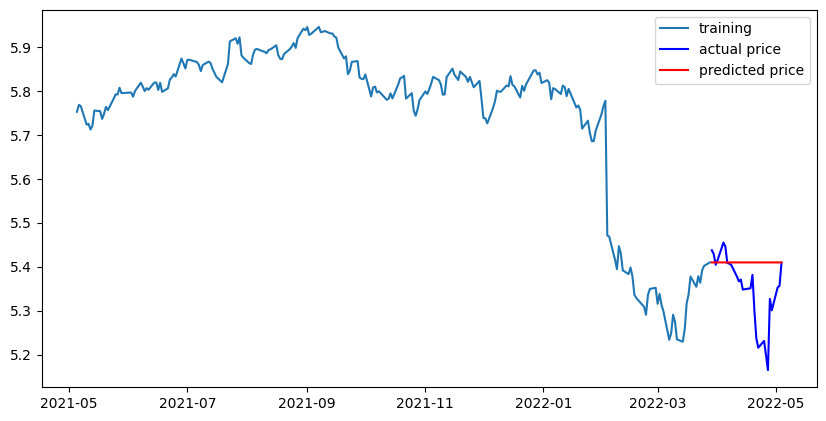

In [142]:
# Forecast : 결과가 fc에 담깁니다. 
fc3 = fitted_m3.forecast(len(test_data3), alpha=0.05)  # 95% conf
fc3 = np.array(fc3)
# Make as pandas series
fc_series3 = pd.Series(fc3, index=test_data3.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data3, label='training')
plt.plot(test_data3, c='b', label='actual price')
plt.plot(fc_series3, c='r',label='predicted price')
plt.legend()
plt.show()

In [143]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse3 = mean_squared_error(np.exp(test_data3), np.exp(fc3))
print('MSE: ', mse3)

mae3 = mean_absolute_error(np.exp(test_data3), np.exp(fc3))
print('MAE: ', mae3)

rmse3 = math.sqrt(mean_squared_error(np.exp(test_data3), np.exp(fc3)))
print('RMSE: ', rmse2)

mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data3))/np.abs(np.exp(test_data3)))
print('MAPE: {:.2f}%'.format(mape3*100))

MSE:  416.9768253717585
MAE:  14.702863878032046
RMSE:  11.641520769887224
MAPE: 7.54%


**Summary**

결과적으로 MAPE 7.54%를 얻을 수 있었다. 차분의 횟수와 p의 값을 수정하며 여러차례 시도해 본 결과, 위의 그래프 분석대로 p=1이며 1차 차분까지 완료했을 때 가장 최적화된 MAPE값을 얻을 수 있었다. 주가 그래프 상에서, 크게 하락하는 구간이 한 구간이 있었는데, 이 때문에 전체적인 시계열 그래프가 불안정 해서 한 번의 차분을 통해 안정성을 더 갖출 수 있었기 때문에 1차 차분에서 가장 우수한 모델의 성능을 보여준 것으로 판단한다.

# **Report**

위의 세 가지 주식 종목에 관하여 시계열 분해와 ARIMA 모델을 통하여 주가를 예측하는 실험을 진행했다. 운이 좋게도, 각 종목마다 차분의 회수를 다르게 적용할 수 있었는데 3번의 실험을 진행하며 주가 데이터가 불안정할 수록(= 주가의 등락 폭이 과할 수록) 더 많은 차분을 필요로 한다는 느낌을 받았다. 또한, ARIMA 모델을 통해 차분의 횟수를 파라미터 값으로 조절하며 그에 따라 모델의 성능이 달라지는 것을 직접 눈으로 확인하며, 차분이 가져다 주는 안정성에 대해서 몸소 체험할 수 있었다.

다만, 아쉬웠던 점은 세 가지 모두 AR모형을 가지고 ARIMA를 활용했는데, MA 모형을 활용할 수 있는 분석이 있었으면 더 좋았겠다라는 생각을 가지게 되었다. 이에 따라 구글링을 해보았지만, 정확하게 MA만 이용하는 적절한 예시를 찾을 수 없었다. 이러한 의문은 앞으로 여러 프로젝트를 진행하며 해소할 수 있을 것이라고 생각한다.

결론적으로, 시계열 데이터의 안정성과 귀무, 대립가설 그리고 이를 활용해 예측하기 위한 데이터 분해작업과 ARIMA 모델의 구조와 활용까지 전반에 걸쳐 수행해볼 수 있는 작업이었다. 또한, 주가 예측이 회귀를 활용하여 어느정도 가능하지만, 위의 결과에서 알 수 있듯이 주식은 과거 데이터 뿐만 아니라 많은 외부요인을 가지고 있기 때문에, 언젠가는 이 모든 것을 총체적으로 활용할 수 있는 AI 모델을 만들 수도 있겠다라는 생각이 들었던 실습이었다.